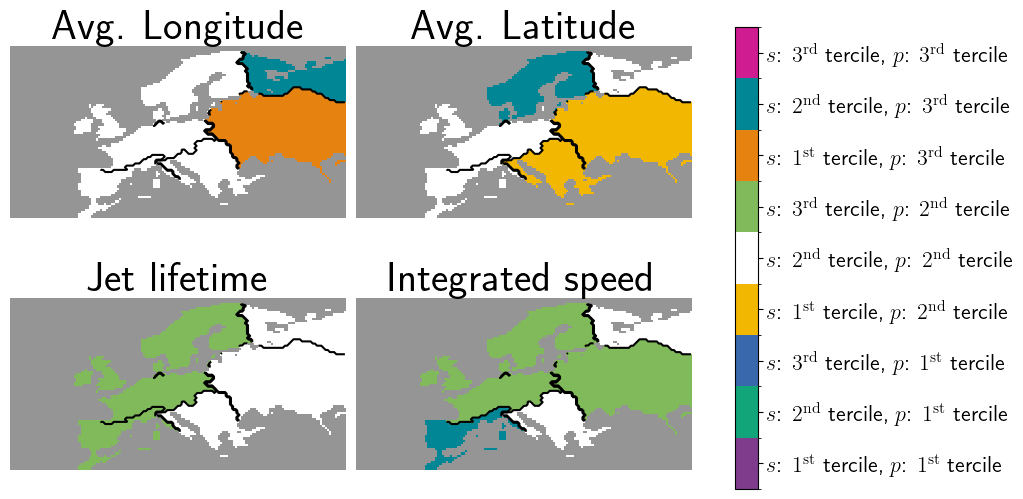

In [ ]:
minlen, maxlen = 5, 10
ds_masked = props_as_ds.where((hs_da <= maxlen) & (hs_da >= minlen))
subset = ["mean_lon", "mean_lat", "persistence", "int"]
significance = True
q = 0.33
n_draws = 10000

lon, lat = duncan_mask.lon.values, duncan_mask.lat.values
inverse_landmask = duncan_mask.copy()
inverse_landmask[:] = 1
inverse_landmask = inverse_landmask.where(duncan_mask.isnull())
centers = {}
meanlens = {}
for ir, region in enumerate(REGIONS):
    com = center_of_mass((duncan_mask == ir + 1).values)
    mean_lat = lat[int(com[0])] + (com[0] % 1) * (lat[1] - lat[0])
    mean_lon = lon[int(com[1])] + (com[1] % 1) * (lon[1] - lon[0])
    centers[region] = [mean_lon, mean_lat]
    lens = 4 * np.asarray([len(hs) for hs in hotspells[ir] if minlen <= len(hs) <= maxlen])
    meanlens[region] = np.round(np.mean(lens)).astype(int)
if subset is None:
    subset = list(props_as_ds.data_vars)
fig_kwargs = {"nrows": 2, "ncols": 2, "figsize": (11, 6)}
fig, axes = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, **fig_kwargs)
fig.subplots_adjust(wspace=0.03)
axes = axes.ravel()
cmap = cmaps.bold
cmap.colors[4] = [1.0, 1.0, 1.0]
norm = BoundaryNorm(np.arange(0, 10), 9)
for k, varname in enumerate(subset):
    da = duncan_mask.copy()
    for ir, region in enumerate(ds_masked.region.values):
        t_ = props_as_ds.time
        n_years = len(np.unique(t_.dt.year))
        year = np.random.randint(n_years, size=n_draws)
        n_days = len(t_) // n_years
        start_days = np.random.randint(n_days - meanlens[region] - 1, size=n_draws)
        start_days = start_days + n_days * year
        indices = start_days[:, None] + np.arange(meanlens[region])[None, :]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            means = np.nanmean(props_as_ds[varname].values[indices], axis=1)
        quantiles = np.nanquantile(means, [q, 1 - q], axis=0)
        anoms = ds_masked[varname].sel(region=region).mean(axis=0, skipna=True).values
        val = 0.5
        for anom, quantiles, factor in zip(anoms, quantiles.T, [1, 3]):
            val += factor * np.searchsorted(quantiles, anom, side="right")
        da = da.where(duncan_mask != ir + 1, val)

    im = axes[k].pcolormesh(
        lon,
        lat,
        da.values,
        shading="nearest",
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
    )
    axes[k].pcolormesh(
        lon,
        lat,
        inverse_landmask,
        shading="nearest",
        transform=ccrs.PlateCarree(),
        cmap="Greys",
        vmin=0.95,
        vmax=1.05,
    )
    axes[k].contour(
        lon,
        lat,
        duncan_mask.values / 6,
        levels=7,
        colors="black",
    )
    axes[k].set_title(PRETTIER_VARNAME[varname], fontsize=30)
    axes[k].axis("off")

ordinals = [r'$1^\mathrm{st}$', r'$2^\mathrm{nd}$', r'$3^\mathrm{rd}$']
cbar = fig.colorbar(im, ax=fig.axes)
_ = cbar.ax.set_yticks(
    np.arange(0.5, 9.5),
    [f'$s$: {ordinals[i]} tercile, $p$: {ordinals[j]} tercile' for j, i in product(range(3), range(3))],
)
fig.savefig(f'{FIGURES}/jet_props_misc/jet_prop_hs_terciles.png')

## Logistic regression (pomped from Burgos et al. 2023)

In [ ]:
predictors = list(product(props_as_ds.data_vars, [0, 1]))
hotspell_binary = hotspells_as_da(props_as_ds.time).astype(int) > 3
best_combinations = {}
max_n_predictors = 20
for k, region in enumerate(REGIONS):
    combinations = [
        [
            predictor,
        ]
        for predictor in predictors
    ]
    best_combinations[region] = {}
    y = hotspell_binary[:, k]
    for n_predictors in trange(1, max_n_predictors):
        coefs, scores = comb_logistic_regression(
            y, props_as_ds_normalized, combinations
        )
        imax = np.argmax(scores[:, 1])
        best_combinations[region][n_predictors] = (
            scores[imax],
            coefs[imax],
            combinations[imax],
        )
        combinations = [
            [*combinations[imax], predictor]
            for predictor in predictors
            if predictor not in combinations[imax]
        ]


100%|██████████| 19/19 [00:11<00:00,  1.61it/s]


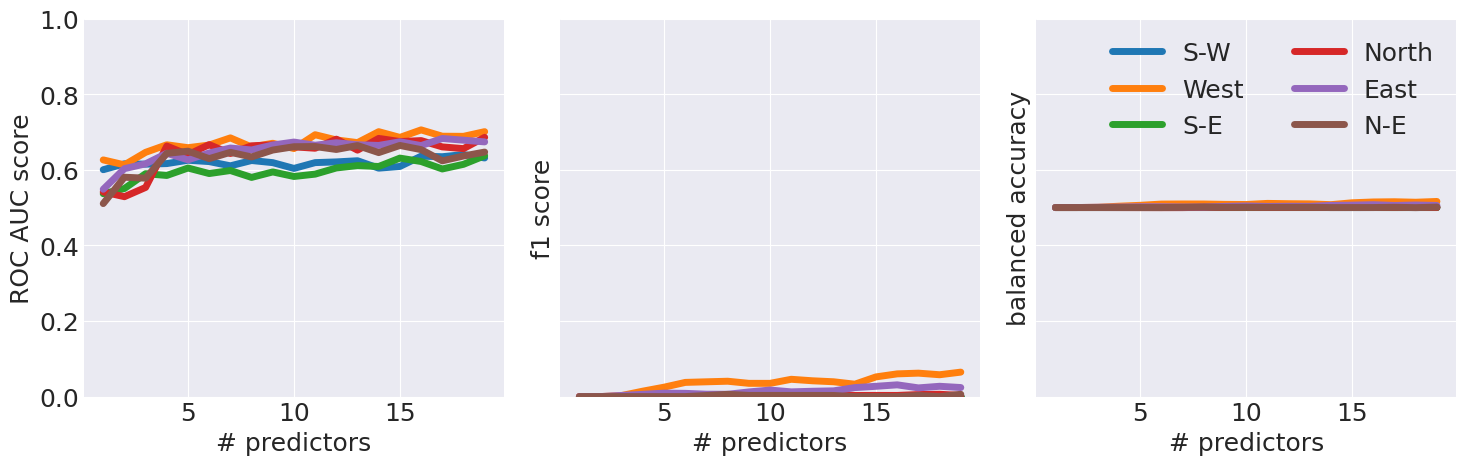

In [ ]:
import seaborn as sns

style_label = "seaborn-v0_8-darkgrid"
with plt.style.context(style_label):
    x = np.arange(1, max_n_predictors)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True, sharey=True)
    titles = ['ROC AUC score', 'f1 score', 'balanced accuracy']
    for i, (ax, title) in enumerate(zip(axes, titles)):
        ax.set_xlabel("# predictors")
        ax.set_ylabel(title)

        sc = np.empty((len(REGIONS), max_n_predictors - 1))
        eb = sc.copy()
        for n_predictors in x:
            sc[:, n_predictors - 1] = [
                best_combinations[region][n_predictors][0][i] for region in REGIONS
            ]
            eb[:, n_predictors - 1] = [
                np.prod(np.exp(np.abs(best_combinations[region][n_predictors][1])))
                for region in REGIONS
            ]
        for k, region in enumerate(REGIONS):
            ax.plot(x, sc[k, :], label=region, lw=5)
        ax.set_ylim([0., 1])
    ax.legend(ncol=2)
    plt.savefig(f"{FIGURES}/jet_props_misc/logreg_elbow_all.png")


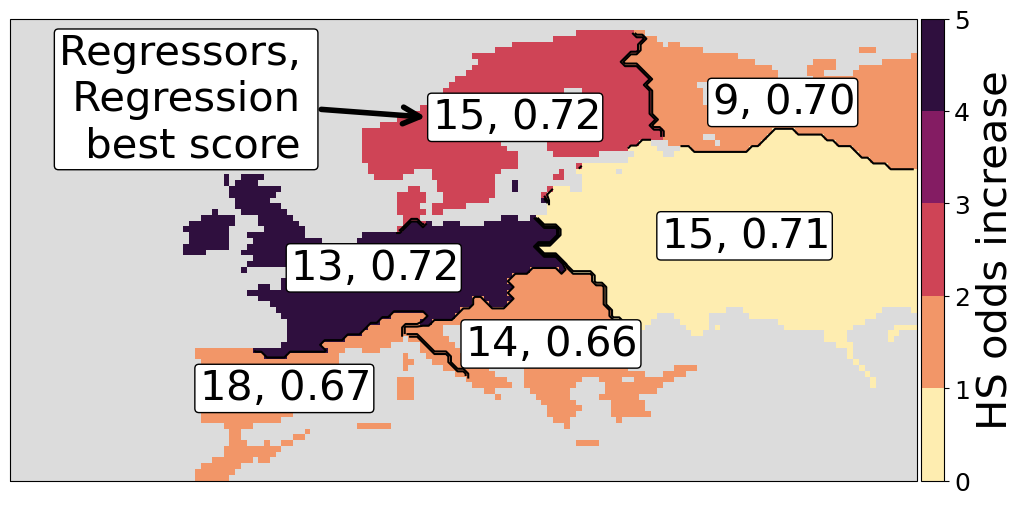

In [ ]:
n_predictors = 1 + np.argmax(scores, axis=1)

duncan_mask = np.abs(xr.open_dataarray(f"{DATADIR}/ERA5/cluster_def.nc"))
lon, lat = duncan_mask.lon.values, duncan_mask.lat.values
height = 6
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(height * 1.2 * len(lon) / len(lat), height),
)

region_centers = {}
for k, region in enumerate(REGIONS):
    com = center_of_mass((duncan_mask == k + 1).values)
    mean_lat = lat[int(com[0])] + (com[0] % 1) * (lat[1] - lat[0])
    mean_lon = lon[int(com[1])] + (com[1] % 1) * (lon[1] - lon[0])
    region_centers[region] = [mean_lon, mean_lat]

inverse_landmask = duncan_mask.copy()
inverse_landmask[:] = 1
inverse_landmask = inverse_landmask.where(duncan_mask.isnull())
bbox = dict(boxstyle="Round", edgecolor="black", facecolor="white", pad=0.1)
# cmap = LinearSegmentedColormap.from_list(
#     "half_cubhelix",
#     sns.cubehelix_palette(start=1, rot=1.5, light=0.55, dark=0.15, hue=2, as_cmap=True)(
#         np.linspace(0.5, 0, 51)
#     ),
# )
cmap = cmaps.matter
# cmap = LinearSegmentedColormap.from_list('half_cubhelix', cmaps.bubblegum(np.linspace(0.0, 0.7, 51)))
this_da = duncan_mask.copy()
for k, region in enumerate(REGIONS):
    eb = np.prod(np.exp(best_combinations[region][n_predictors[k]][1]))
    sc = best_combinations[region][n_predictors[k]][0]
    this_da = this_da.where(duncan_mask != k + 1, eb)
    ax.text(
        *region_centers[region],
        f"${n_predictors[k]}$, ${sc:.2f}$",
        bbox=bbox,
        va="bottom" if region == "Arctic" else "center",
        ha="center",
        fontsize=30,
    )
im = ax.pcolormesh(
    lon,
    lat,
    this_da.values,
    shading="nearest",
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=BoundaryNorm(np.arange(0, 6, 1), cmap.N),
)
ax.pcolormesh(
    lon,
    lat,
    inverse_landmask,
    shading="nearest",
    transform=ccrs.PlateCarree(),
    cmap="Greys",
    vmin=0.985,
    vmax=1.05,
)
cbar = fig.colorbar(im, pad=0.004, spacing='proportional')
cbar.ax.set_ylabel("HS odds increase", fontsize=30)
ax.contour(lon, lat, duncan_mask.values / 6, levels=7, colors="black")
xy = (region_centers["North"][0] - 7.5, region_centers["North"][1])
ax.annotate(
    "Regressors, \n Regression \n best score",
    xy=xy,
    xytext=(-10, 65),
    bbox=bbox,
    arrowprops={"arrowstyle": "->", "facecolor": "black", "lw": 4},
    transform=ccrs.PlateCarree(),
    ha="center",
    va="center",
    fontsize=30,
)
plt.savefig(f"{FIGURES}/jet_props_misc/odds_increase_lr.png", dpi=300)


## Random forest regression

In [ ]:
predictors = list(product(props_as_ds.data_vars, [0, 1]))
hotspell_binary = hotspells_as_da(props_as_ds.time).astype(int) > 3
best_combinations = {}
max_n_predictors = 10
for k, region in enumerate(REGIONS):
    combinations = [
        [
            predictor,
        ]
        for predictor in predictors
    ]
    best_combinations[region] = {}
    y = hotspell_binary[:, k]
    for n_predictors in trange(1, max_n_predictors + 1):
        feature_importance, scores = comb_random_forest(
            y, props_as_ds_normalized, combinations
        )
        imax = np.argmax(scores[:, 1])
        best_combinations[region][n_predictors] = (
            scores[imax],
            feature_importance[imax],
            combinations[imax],
        )
        if n_predictors != max_n_predictors:
            combinations = [
                [*combinations[imax], predictor]
                for predictor in predictors
                if predictor not in combinations[imax]
            ]


100%|██████████| 10/10 [03:07<00:00, 18.75s/it]


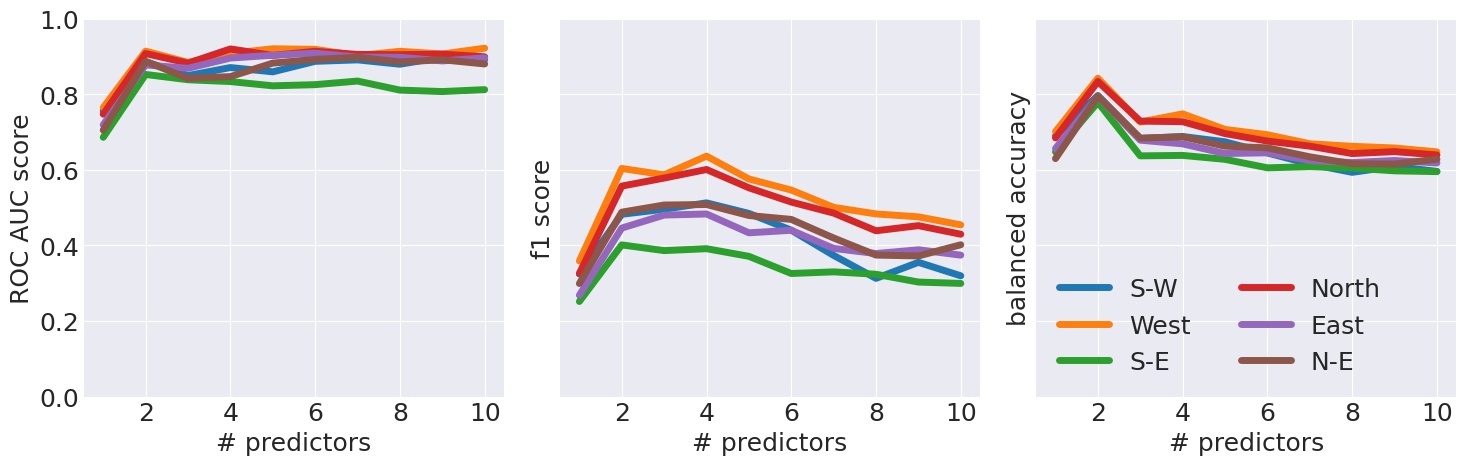

In [ ]:
import seaborn as sns

style_label = "seaborn-v0_8-darkgrid"
with plt.style.context(style_label):
    x = np.arange(1, max_n_predictors + 1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True, sharey=True)
    titles = ['ROC AUC score', 'f1 score', 'balanced accuracy']
    for i, (ax, title) in enumerate(zip(axes, titles)):
        ax.set_xlabel("# predictors")
        ax.set_ylabel(title)

        sc = np.empty((len(REGIONS), max_n_predictors))
        eb = sc.copy()
        for n_predictors in x:
            sc[:, n_predictors - 1] = [
                best_combinations[region][n_predictors][0][i] for region in REGIONS
            ]
            eb[:, n_predictors - 1] = [
                np.prod(np.exp(np.abs(best_combinations[region][n_predictors][1])))
                for region in REGIONS
            ]
        for k, region in enumerate(REGIONS):
            ax.plot(x, sc[k, :], label=region, lw=5)
        ax.set_ylim([0., 1])
    ax.legend(ncol=2)
    plt.savefig(f"{FIGURES}/jet_props_misc/forest_elbow_all.png")


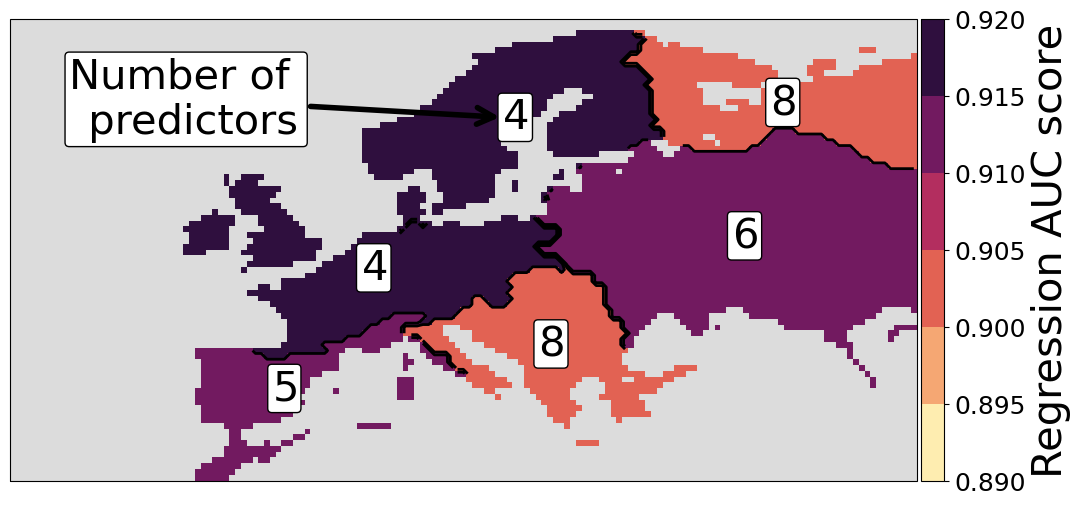

In [ ]:
n_predictors = 1 + np.argmax(sc, axis=1)
duncan_mask = np.abs(xr.open_dataarray(f"{DATADIR}/ERA5/cluster_def.nc"))
lon, lat = duncan_mask.lon.values, duncan_mask.lat.values
height = 6
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(height * 1.2 * len(lon) / len(lat), height),
)

region_centers = {}
for k, region in enumerate(REGIONS):
    com = center_of_mass((duncan_mask == k + 1).values)
    mean_lat = lat[int(com[0])] + (com[0] % 1) * (lat[1] - lat[0])
    mean_lon = lon[int(com[1])] + (com[1] % 1) * (lon[1] - lon[0])
    region_centers[region] = [mean_lon, mean_lat]

inverse_landmask = duncan_mask.copy()
inverse_landmask[:] = 1
inverse_landmask = inverse_landmask.where(duncan_mask.isnull())
bbox = dict(boxstyle="Round", edgecolor="black", facecolor="white", pad=0.1)
cmap = cmaps.matter
this_da = duncan_mask.copy()
for k, region in enumerate(REGIONS):
    sc_ = best_combinations[region][n_predictors[k]][0]
    this_da = this_da.where(duncan_mask != k + 1, sc_)
    ax.text(
        *region_centers[region],
        f"${n_predictors[k]}$",
        bbox=bbox,
        fontweight="bold",
        va="bottom" if region == "Arctic" else "center",
        ha="center",
        fontsize=30,
    )
im = ax.pcolormesh(
    lon,
    lat,
    this_da.values,
    shading="nearest",
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=BoundaryNorm(np.linspace(0.89, 0.92, 7), cmap.N),
)
ax.pcolormesh(
    lon,
    lat,
    inverse_landmask,
    shading="nearest",
    transform=ccrs.PlateCarree(),
    cmap="Greys",
    vmin=0.985,
    vmax=1.05,
)
cbar = fig.colorbar(im, pad=0.004, spacing="proportional")
cbar.ax.set_ylabel("Regression AUC score", fontsize=30)
ax.contour(
    lon, lat, duncan_mask.values, levels=0.5 + np.arange(1, 6), colors="black", linewidths=2,
    algorithm='mpl2005'
)
xy = (region_centers["North"][0] - 1.1, region_centers["North"][1])
ax.annotate(
    "Number of \n predictors",
    xy=xy,
    xytext=(-10, 65),
    bbox=bbox,
    arrowprops={"arrowstyle": "->", "facecolor": "black", "lw": 4},
    transform=ccrs.PlateCarree(),
    ha="center",
    va="center",
    fontsize=30,
)
plt.savefig("Figures/jet_props_misc/prediction_score_forest.png", dpi=300)

In [ ]:
jets = ['s', 'p']
for ir, region in enumerate(REGIONS):
    print(region)
    print()
    best_combination_str = [
        ', '.join((varname, jets[idx])) for varname, idx in best_combinations[region][n_predictors[ir]][2]
    ]
    print('useful predictors : ', best_combination_str)
    print('Relative importance : ', best_combinations[region][n_predictors[ir]][1])
    print('Score : ', best_combinations[region][n_predictors[ir]][0])
    print()

S-W

useful predictors :  ['persistence, s', 'persistence, p', 'mean_lon, p', 'mean_lat, p', 'mean_lat, s']
Relative importance :  [0.183  0.2428 0.2217 0.2288 0.1237]
Score :  0.913427963138318

West

useful predictors :  ['persistence, s', 'persistence, p', 'mean_lat, p', 'int, p']
Relative importance :  [0.277  0.2699 0.2364 0.2167]
Score :  0.916199476299181

S-E

useful predictors :  ['persistence, s', 'persistence, p', 'mean_lat, p', 'mean_lon, p', 'tilt, p', 'int, p', 'mean_lon, s', 'mean_lat, s']
Relative importance :  [0.0881 0.1601 0.1495 0.1454 0.1325 0.1359 0.1134 0.0752]
Score :  0.904729248086703

North

useful predictors :  ['persistence, s', 'persistence, p', 'mean_lat, p', 'int, p']
Relative importance :  [0.2415 0.256  0.2759 0.2266]
Score :  0.919911792474379

East

useful predictors :  ['persistence, s', 'persistence, p', 'mean_lat, p', 'mean_lon, p', 'tilt, p', 'int_low, s']
Relative importance :  [0.1365 0.204  0.2141 0.1922 0.1654 0.0878]
Score :  0.9119171826161

### For a whole region, averaged

In [ ]:
timesteps_before = 16
ds_masked = apply_hotspells_mask_v2(props_as_ds, 16)